# Arctic Permafrost Modeling

ATS was initially developed out of a desire to model Arctic permafrost using the best available understanding of cryosphere processes, including subsurface flow in partially saturated, partially frozen soils.  These simulations form the basis for doing this work, and represent an approach designed for continuous permafrost.

This demo also is useful for seeing how layering works in ATS, as there are heterogeneous properties throughout (peat and mineral soil layers).

The spinup of this sequence is as follows:

* freezeup: Freeze the steady-state water table from below, establishing a saturated ice table.

Applications in real domains should also likely run several years of cyclic steady-state spinup, driving a column with idealized meteorological data to generate a climatologically "typical" year.  This establishes a permafrost vs active layer, reasonable saturation state, etc.

After these, many choices are available.  

* column_permafrost: This demonstrates a standard 1D column run with full transient physics.
* column_transect: This adds 2D topography and snow distribution, ensuring that snow fills low lying areas first.


In [1]:
%matplotlib inline
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'docs', 'documentation', 'source', 'ats_demos'))

import ats_xdmf
import plot_column_data
import colors
from itertools import islice
import numpy as np
import matplotlib.cm
from matplotlib import pyplot as plt
import run_demos

## spinup: Freeze steady-state to generate ice column

Transient simulations in areas of continuous permafrost are initialized in the winter to make spinup simpler.  Therefore we start from a fully frozen domain (instead of the partially frozen domain that would be required for starting any other time of year).  

Transient simulations in areas of seasonally frozen ground, however, would typically be started in the summer for the same reason.  Transient simulations in areas of discontinuous permafrost or areas with taliks are challenging, and typically need more extensive spinup processes.

For continuous permafrost, to establish this fully-frozen domain, we freeze the hydrostatic water column from below until the solution reaches steady-state again.  This "pseudo-transient" approach is easier for solvers than solving the steady-state problem.  This is done in the subsurface only, solving coupled Richards and energy equations.

Here we look at a study from the Barrow Environmental Observatory in Utqiagvik, AK.  The bottom boundary temperature is set at -9 F, which is, according to deep borehole data, a reasonable temperature for deep permafrost in Barrow.  As the column freezes, water expands to form ice, pushing the water above it up.  This results in a careful balance -- we want to set the bottom pressure in `freezeup` such that, when frozen, the ice table is near the surface, but not above it (which would break the problem here because a no flux condition is put on that top surface).  The calculation of such a pressure is difficult, as it depends upon soil properties, freezing rates, and other dynamic things, so a test-and-check approach is taken.

First, an initial water table location is specified by the hydrostatic initial condition.  After the simulation, if the resulting ice table is too high, the pressure in the top cell will blow up, and the process is repeated with a lower initial water table.   If the resulting ice table is too low, the entire active layer will happen in an unsaturated zone, and the soil will never saturate, so the initial water table must be adjusted upwards.  Typically, for coastal polygonal permafrost, the soil is quite wet, so we work to get the ice table as close to the surface as possible.  More thought might be required for a drier condition, but remember that too wet is rarely an issue (things can drain over a few dynamic years fairly quickly as long as they thaw, but filling up from too dry takes a much longer time).  Bisection on the initial water table can be used to quickly find a value that hits an appropriate ice table level.

NOTE: From here on, transient problems are plotted such that early times have low intensity colors, and late times are high intensity colors.  The initial condition is therefore the lightest line, while the darkest line is the final, steady-state solution.

NOTE: This run takes some time (especially if the code is built in debug mode), up to ~10 minutes.

In [2]:
#
# plot the solution
#
def plot(dirname, axs):
    """A generic plotting function that plots saturation as a function of depth."""

    plot_column_data.plot_subsurface(vis, ['pressure',], axs[0], cmap='jet')
    axs[0].set_xlabel('pressure [Pa]')
    ax.set_ylabel('z [m]')
    
    plot_column_data.plot_subsurface(vis, ['saturation_liquid',], axs[1], None, cmap='jet')
    axs[0].set_xlabel('saturation [-]')
    ax.set_ylabel('z [m]')

def plot(testname, axs, style):
    directory = testname+".demo"
    run_demos.run_demo_local(testname)
    
    # load the data
    vis = ats_xdmf.VisFile(directory, time_unit='d')
    vis.loadMesh(columnar=True)
    dati = np.array([vis.getArray(v) for v in ["pressure", "pressure", "saturation_liquid", 
                                    "saturation_ice", "saturation_gas", "temperature"]])
    times = vis.times
    
    ice = colors.cm_mapper(-10000, times[-1], colors.ice_cmap())
    water = colors.cm_mapper(-10000, times[-1], colors.water_cmap())
    gas = colors.cm_mapper(-10000, times[-1], colors.gas_cmap())    
    
    # plot saturation of liquid, pressure
    z = vis.centroids[:,2]
    for i,t in enumerate(times):
        label = False
        if i == len(times)-1:
            axs[0].plot(dati[2,i,:],z, style, color=water(t), label='liquid')
            axs[0].plot(dati[3,i,:],z, style, color=ice(t), label='ice')
            axs[0].plot(dati[4,i,:],z, style, color=gas(t), label='gas')
        else:
            axs[0].plot(dati[2,i,:],z, style, color=water(t))
            axs[0].plot(dati[3,i,:],z, style, color=ice(t))
            axs[0].plot(dati[4,i,:],z, style, color=gas(t))
        axs[2].plot(dati[5,i,:],z, style, color=gas(t))
        axs[1].plot(dati[1,i,:],z, style, color=water(t))
        axs[0].plot(dati[2,i,:],z, style, color=water(t))
        axs[0].plot(dati[3,i,:],z, style, color=ice(t))
        axs[0].plot(dati[4,i,:],z, style, color=gas(t))

def decorate(axs):
    axs[0].set_xlabel('saturation [-]')
    axs[0].set_ylabel('z-coordinate [m]')
    axs[1].set_xlabel('pressure [Pa]')
    axs[2].set_xlabel('temperature [K]')
    axs[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axs[0].set_xlim([-.1,1.1])
    axs[0].legend()

            

  Test log file : LOGS/ats-tests-2024-04-22_13-35-49.testlog
Running ATS demo problems :
06_arctic_hydrology  | .

----------------------------------------------------------------------
Regression test summary:
    Total run time: 64.0219 [s]
    Total tests : 1
    Tests run : 1
    All tests passed.




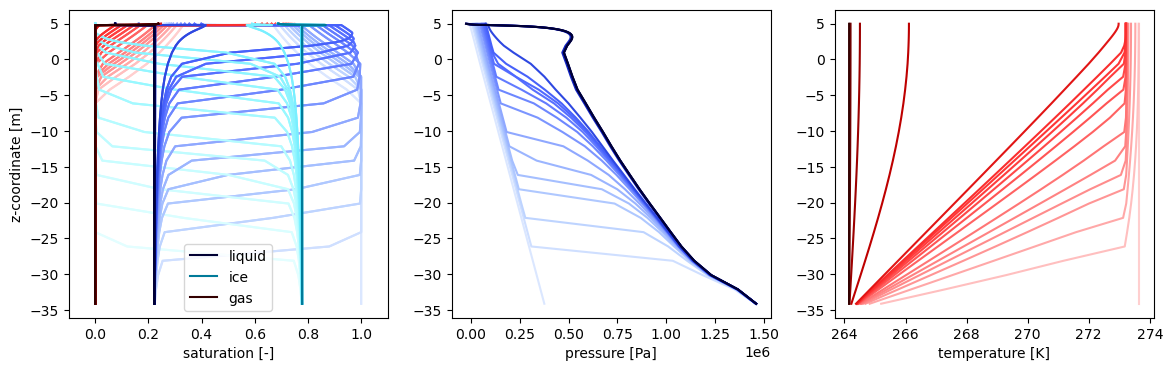

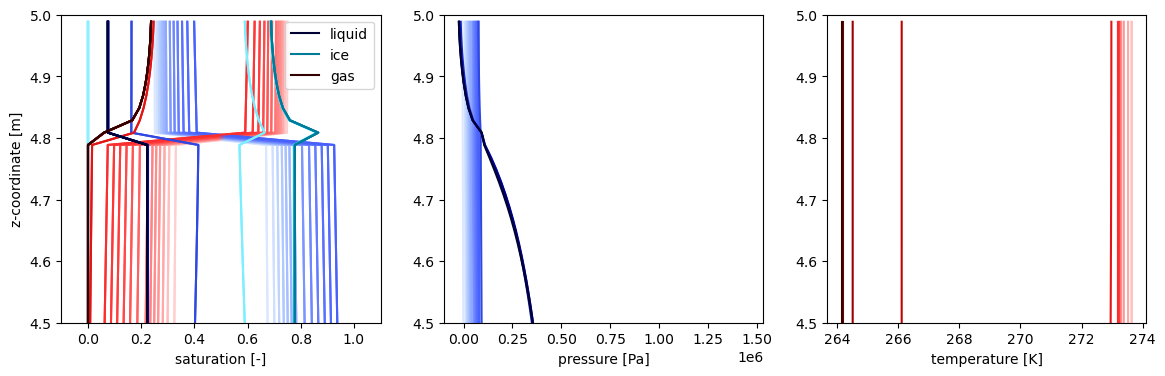

In [3]:

# full column
fig, axs = plt.subplots(1,3, figsize=(14,4))
plot('freezeup', axs, '-')
decorate(axs)

# and a zoomed version that shows the very shallow subsurface
fig, axs = plt.subplots(1,3, figsize=(14,4))
plot('freezeup', axs, '-')
decorate(axs)
axs[0].set_ylim([4.5,5])
axs[1].set_ylim([4.5,5])
axs[2].set_ylim([4.5,5])


plt.show()

## Dynamic fully coupled run with annual cyclic steady state forcing

Next, the permafrost_column run demonstrates the typical transient column run.  This includes all thermal hydrology processes:

* subsurface flow (modified Richards)
* subsurface energy
* surface flow
* surface energy
* surface energy balance

This model is forced with meteorological data.  Here we will use DayMet, which provides daily historical QA'd datasets for meteorological data on a 1km US grid, and covers Alaska.  These datasets were created using DayMet for Barrow:

```python $ATS_SRC_DIR/tools/utils/daymet_to_ats.py 71.2718 -156.6202```

and then smoothed to generate spinup data via:

```python $ATS_SRC_DIR/tools/utils/smooth_met.py -n 10 daymet_raw_71p2718_-156p6202.h5```

This is called a spinup run because it sets a typical cyclic steady state, and puts the permafrost a reasonable state to then do dynamic, "real data" runs with met data from real years instead of averaged, typical years.  These dynamic runs use the same transient processes, just different forcing data.


In [4]:
# plot the solution
def plot(testname, axs, style):
    directory = testname+".demo"
    run_demos.run_demo_local(testname)
    
    # load the data
    vis = ats_xdmf.VisFile(directory, time_unit='d')
    vis.loadMesh(columnar=True)
    dati = np.array([vis.getArray(v) for v in ["pressure", "pressure", "saturation_liquid", 
                                    "saturation_ice", "saturation_gas", "temperature"]])
        
    viss = ats_xdmf.VisFile(directory, 'surface', time_unit='d')
    viss.loadMesh(columnar=True)
    
    vissn = viss
    vissn.loadMesh(columnar=True)    
        
    # convert times to days
    times = vis.times

    ice = colors.cm_mapper(-10, times[-1], colors.ice_cmap())
    water = colors.cm_mapper(-10, times[-1], colors.water_cmap())
    gas = colors.cm_mapper(-10, times[-1], colors.gas_cmap())    
    
    # plot saturation of liquid, pressure
    z = vis.centroids[:,2]
    for (i,t) in islice(enumerate(times),0,None,10):
        
        axs[1].plot(dati[5,i,:],z, style, color=gas(t))
        if i == len(times)-1:
            axs[0].plot(dati[2,i,:],z, style, color=water(t), label='liquid')
            axs[0].plot(dati[3,i,:],z, style, color=ice(t), label='ice')
            axs[0].plot(dati[4,i,:],z, style, color=gas(t), label='gas')
        else:
            axs[0].plot(dati[2,i,:],z, style, color=water(t))
            axs[0].plot(dati[3,i,:],z, style, color=ice(t))
            axs[0].plot(dati[4,i,:],z, style, color=gas(t))
            
    # inset -- plot surface water
    pd = viss.getArray('surface-ponded_depth')
    axs[2].plot(times, pd, 'b')
    if pd.max() > 0:
        axs[2].set_ylim([-.1*pd.max(), pd.max()])

    # plot snow
    snow = vissn.getArray('snow-depth')
    snow = snow + pd
    axs[2].plot(times, snow, 'c')
    if snow.max() > 0:
        axs[2].set_ylim([-.1*snow.max(), snow.max()])
        
    # plot surface temp
    surf_T = viss.getArray("surface-temperature")
    axs[3].plot(times, surf_T, 'r')
    
    # plot snow temp
    snow_T = vissn.getArray('snow-temperature')
    snow_T[0] = np.nan # this is initially zero which screws up the plot
    axs[3].plot(times, snow_T, 'm')

def decorate(axs):
    axs[0].set_xlim([-.1,1.1])
    axs[0].set_xlabel('saturation [-]')
    axs[0].set_ylabel('z-coordinate [m]')
    axs[0].legend()
    axs[1].set_xlabel('temperature [K]')
    axs[2].set_xlabel('time [d]')
    axs[2].set_ylabel('ponded (b) and snow (c) depth [m]')
    axs[3].set_ylabel('surface (r) and snow (m) T [K]')


  Test log file : LOGS/ats-tests-2024-04-22_13-36-54.testlog
Running ATS demo problems :
06_arctic_hydrology  | .

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.




----------------------------------------------------------------------
Regression test summary:
    Total run time: 20.0399 [s]
    Total tests : 1
    Tests run : 1
    All tests passed.




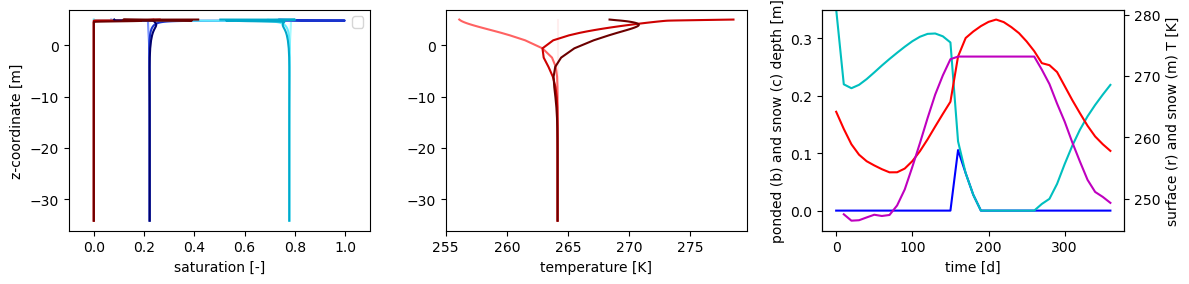

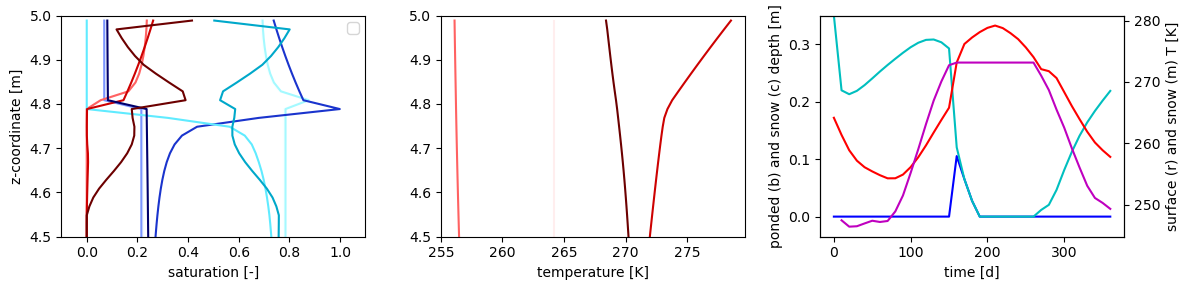

In [5]:
fig, axs = plt.subplots(1,3, figsize=(12,3))
twinax = axs[2].twinx()
axs = list(axs)

axs.append(twinax)

plot('permafrost_column', axs, '-')
decorate(axs)
plt.tight_layout()
              
# zoom
fig, axs = plt.subplots(1,3, figsize=(12,3))
twinax = axs[2].twinx()
axs = list(axs)
axs.append(twinax)

plot('permafrost_column', axs, '-')
decorate(axs)
axs[0].set_ylim((4.5,5))
axs[1].set_ylim((4.5,5))
plt.tight_layout()
plt.show()

## permafrost_transect: Dynamic run with snow distribution

For 2D permafrost runs including topography variation, it is often crucial to allow snow to preferentially accumulate in low-lying areas, as is typical of wind-blow snow.  ATS has a very simple version of this.  The 2D demo, `permafrost_transect`, would run for longer times, but would typically be done on a few cores for a longer time, so we simply demonstrate the snow drifting here by running the first 10 days.


  Test log file : LOGS/ats-tests-2024-04-22_13-37-14.testlog
Running ATS demo problems :
06_arctic_hydrology  | .

----------------------------------------------------------------------
Regression test summary:
    Total run time: 32.0156 [s]
    Total tests : 1
    Tests run : 1
    All tests passed.




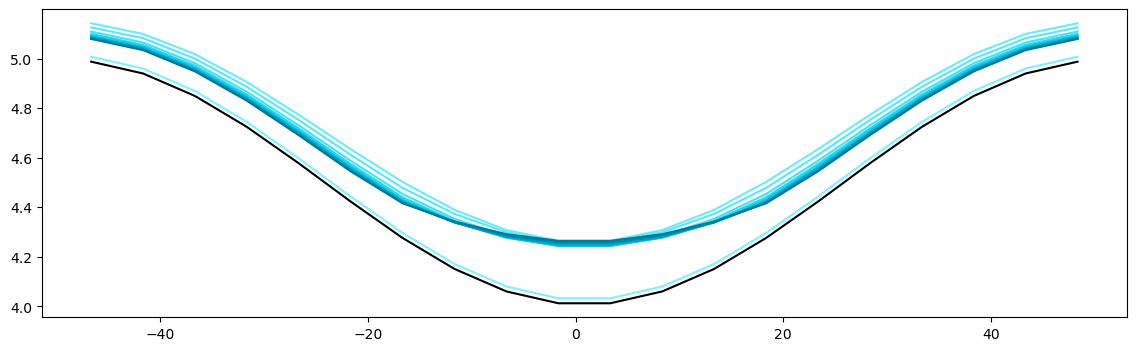

In [6]:
# plot the solution
def plot(testname, axs, style):
    directory = testname+".demo"
    run_demos.run_demo_local(testname)
    
    # load the data
    vis = ats_xdmf.VisFile(directory, 'surface', time_unit='d')
    vis.loadMesh(columnar=True)
    dati = np.array([vis.getArray(v) for v in ["snow-depth","surface-elevation"]])

    x = vis.centroids[:,0,0]
    times = vis.times

    snow = colors.cm_mapper(-10, times[-1], colors.ice_cmap())

    axs.plot(x, dati[1,0,:], 'k')
    for (i,t) in enumerate(times):
        axs.plot(x, dati[1,0,:]+dati[0,i,:], color=snow(t), label='snow')


def decorate(axs):
    axs.set_xlabel('x coordinate [m]')
    axs.set_ylabel('z coordinate [m]')
    axs.legend()
    
fig, axs = plt.subplots(1,1, figsize=(14,4))
plot('permafrost_transect', axs, '-')